In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy, scipy.stats
import pickle
import shapely.geometry, shapely.ops
from collections import Counter

from tqdm import tqdm_notebook as tqdm, tnrange as trange
import pydot
import matplotlib.pyplot as plt
import IPython.display

In [3]:
with open('building-footprints-annotations.pickle', 'rb') as dumpfile:
    dump = pickle.load(dumpfile)
    polygons = dump['polygons']
    num_contributions = dump['num_contributions']
    num_correct = dump['num_correct']
    num_incorrect = dump['num_incorrect']
    del dump

## Measuring Agreement using IoU of Polygons

### Single-Polygon Buildings

In [4]:
def poly_iou(a, b):
    
    if isinstance(a, dict):
        a = a['coordinates']
    if isinstance(b, dict):
        b = b['coordinates']
        
    a = [shapely.geometry.Polygon(p) for p in a]
    b = [shapely.geometry.Polygon(p) for p in b]
    
    poly1 = a[0] if len(a) == 1 else shapely.ops.cascaded_union(a)
    poly2 = b[0] if len(b) == 1 else shapely.ops.cascaded_union(b)
    
    intsct_area = poly1.intersection(poly2).area
    return intsct_area / (poly1.area + poly2.area - intsct_area)

In [5]:
buildings_with_gt = [pid for pid, annotations in polygons.items()
                         if all(len(polys) == 1 for polys in annotations.values())
                         and any('correct' in next(iter(polys.values())) for polys in annotations.values())]
len(buildings_with_gt)

150

In [6]:
demo_polys = [
    polygons[101514][47627739778][561603]['coordinates'],
    polygons[101514][695432082202][718525]['coordinates'],
    polygons[101514][511700202172][638576]['coordinates'],
    polygons[101514][1045712977611][543610]['coordinates']
]

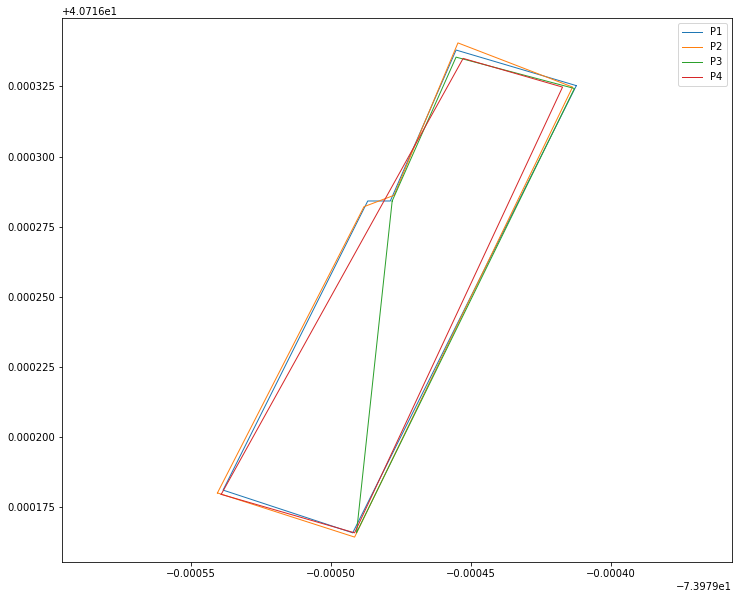

In [7]:
plt.figure(figsize=(12,10))
for i, poly in enumerate(demo_polys, 1):
    plt.plot([x for x, y in poly[0]], [y for x, y in poly[0]], linewidth=1, label='P{}'.format(i))
plt.axis('equal')
plt.legend()
plt.show()

In [8]:
md_table = '||' + '|'.join('P{}'.format(i) for i in range(1, len(demo_polys) + 1)) + '|\n'
md_table += '|:-:' * (len(demo_polys) + 1) + '\n'
for i, poly1 in enumerate(demo_polys, 1):
    md_table += '|**P{}**|'.format(i)
    for poly2 in demo_polys:
        md_table += '{:.3f}|'.format(poly_iou(poly1, poly2))
    md_table += '\n'

IPython.display.Markdown(md_table)

||P1|P2|P3|P4|
|:-:|:-:|:-:|:-:|:-:
|**P1**|1.000|0.961|0.567|0.898|
|**P2**|0.961|1.000|0.557|0.883|
|**P3**|0.567|0.557|1.000|0.548|
|**P4**|0.898|0.883|0.548|1.000|


### Multi-Polygon Buildings

In [9]:
def annotation_agreement(a, b):
    
    ious = np.array([[poly_iou(p1, p2) for p2 in b.values()] for p1 in a.values()])
    matched_ious = []
    for _ in range(min(len(a), len(b))):
        i, j = np.unravel_index(ious.argmax(), ious.shape)
        matched_ious.append(ious[i,j])
        ious[i,:] = 0
        ious[:,j] = 0
    return sum(matched_ious) / max(len(a), len(b))

In [10]:
multi_buildings = [pid for pid, annotations in polygons.items()
                       if all(len(polys) > 2 for polys in polygons[pid].values())]
len(multi_buildings)

103

In [11]:
demo_annotations = [
    polygons[101530][231314224250],
    polygons[101530][388791582533],
    polygons[101530][1054895102606]
]

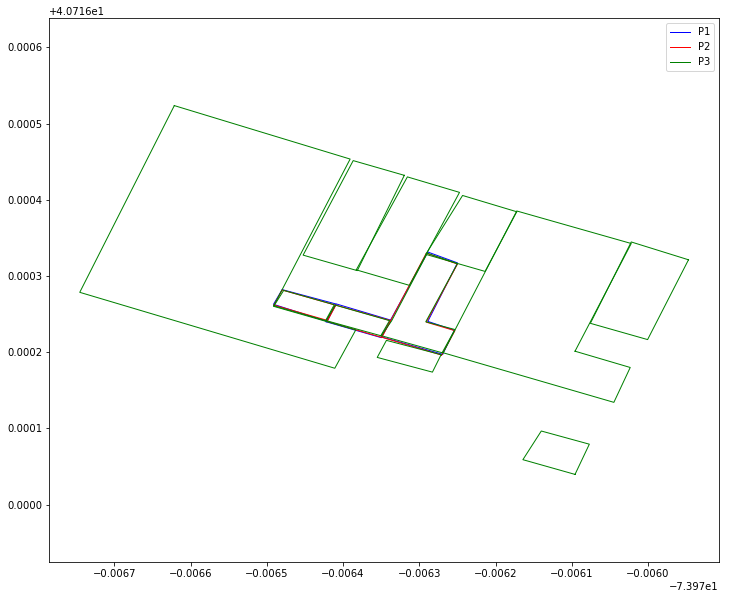

In [12]:
plt.figure(figsize=(12,10))
for i, (ann, c) in enumerate(zip(demo_annotations, ['b', 'r', 'g']), 1):
    for j, poly in enumerate(ann.values()):
        plt.plot([x for x, y in poly['coordinates'][0]], [y for x, y in poly['coordinates'][0]], linewidth=1, c=c, label='P{}'.format(i) if j == 0 else None)
plt.axis('equal')
plt.legend()
plt.show()

In [13]:
annotation_agreement(demo_annotations[0], demo_annotations[1]), \
annotation_agreement(demo_annotations[0], demo_annotations[2]), \
annotation_agreement(demo_annotations[1], demo_annotations[2])

(0.9302877297862248, 0.24218494171798355, 0.2510820109947167)

## Fix/Remove Invalid Polygons

In [14]:
invalid_polys = [(gid, uid, pid) for gid, annotations in polygons.items()
                                 for uid, polys in annotations.items()
                                 for pid, poly in polys.items()
                                 if not shapely.geometry.Polygon(poly['coordinates'][0]).is_valid]

num_polys_total = sum(len(polys) for annotations in polygons.values() for polys in annotations.values())

print('{} / {} ({:.2%})'.format(len(invalid_polys), num_polys_total, len(invalid_polys) / num_polys_total))

1108 / 128089 (0.87%)


In [15]:
def fix_poly(poly):
    
    orig = shapely.geometry.Polygon(poly)
    
    best_removal, best_removal_diff = -1, None
    for i in range(len(poly)):
        new_poly = shapely.geometry.Polygon([xy for j, xy in enumerate(poly) if j != i])
        if new_poly.is_valid:
            diff = abs(new_poly.area - orig.area)
            if (best_removal_diff is None) or (diff < best_removal_diff):
                best_removal = i
                best_removal_diff = diff
    
    if best_removal_diff is None:
        return None
    else:
        return [xy for j, xy in enumerate(poly) if j != best_removal], best_removal_diff / orig.area

In [16]:
fixed_polys = [fix_poly(polygons[gid][uid][pid]['coordinates'][0]) for gid, uid, pid in invalid_polys]

print('Non-fixable:    {:3d}'.format(sum(1 for fixed_poly in fixed_polys if fixed_poly is None)))
print('Over Threshold: {:3d}'.format(sum(1 for fixed_poly in fixed_polys if (fixed_poly is not None) and (fixed_poly[1] > 1e-2))))

Non-fixable:    319
Over Threshold: 291


In [17]:
sorted(range(len(fixed_polys)), key = lambda i: -fixed_polys[i][1] if (fixed_polys[i] is not None) and (fixed_polys[i][1] <= 1e-2) else 0)[:10]

[38, 250, 422, 98, 482, 907, 84, 474, 553, 841]

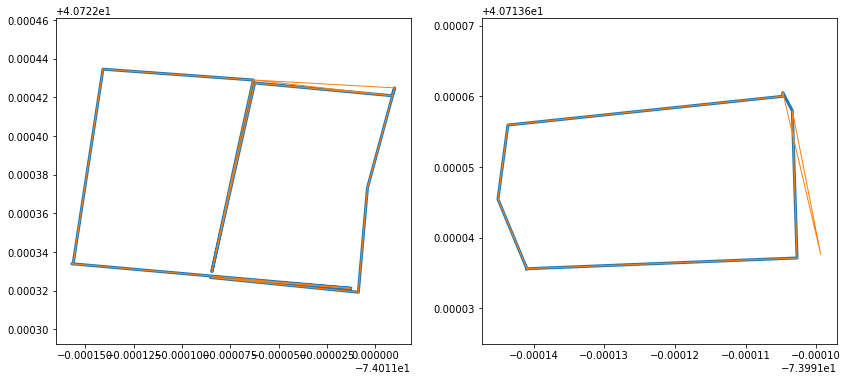

In [18]:
p1 = polygons[invalid_polys[38][0]][invalid_polys[38][1]][invalid_polys[38][2]]['coordinates'][0]
p2 = polygons[invalid_polys[250][0]][invalid_polys[250][1]][invalid_polys[250][2]]['coordinates'][0]
new_p1 = fixed_polys[38][0]
new_p2 = fixed_polys[250][0]

fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot([x for x, y in new_p1], [y for x, y in new_p1], linewidth=3.0)
ax[0].plot([x for x, y in p1], [y for x, y in p1], linewidth=1.0)
ax[1].plot([x for x, y in new_p2], [y for x, y in new_p2], linewidth=3.0)
ax[1].plot([x for x, y in p2], [y for x, y in p2], linewidth=1.0)
ax[0].axis('equal')
ax[1].axis('equal')
plt.show()

In [19]:
for (gid, uid, pid), fixed_poly in zip(invalid_polys, fixed_polys):
    if (gid in polygons) and (uid in polygons[gid]):
        if (fixed_poly is not None) and (fixed_poly[1] <= 1e-2):
            polygons[gid][uid][pid]['coordinates'][0] = fixed_poly[0]
        else:
            del polygons[gid][uid]
            if len(polygons[gid]) == 0:
                del polygons[gid]

In [20]:
num_contributions = Counter(uid for annotations in polygons.values() for uid in annotations.keys())
len(num_contributions), num_contributions.most_common(10)

(3928,
 [(551515923020, 4000),
  (691294318015, 2931),
  (903312077352, 2649),
  (229864209236, 2221),
  (258905384618, 1733),
  (1094509667768, 1692),
  (896680463060, 1520),
  (327883322652, 1389),
  (622063345769, 1332),
  (1045712977611, 1331)])

## Collaboration graph

In [21]:
user_ids = list(num_contributions.keys())
user_ind = { uid : i for i, uid in enumerate(user_ids) }
len(user_ids)

3928

In [22]:
collaboration = np.zeros((len(user_ids), len(user_ids)), dtype=np.uint32)
for annotations in polygons.values():
    annotating_users = list(annotations.keys())
    for i in range(len(annotating_users)):
        u1 = user_ind[annotating_users[i]]
        for j in range(i+1, len(annotating_users)):
            u2 = user_ind[annotating_users[j]]
            collaboration[u1,u2] += 1
            collaboration[u2,u1] += 1

print('Number of collaborations: {:.0f}'.format(collaboration.sum() // 2))
print('Maximum number of collaborations of two users: {}'.format(collaboration.max()))
print('Number of user interactions: {:.0f} ({:.3%})'.format(
        (collaboration > 0).sum() // 2,
        ((collaboration > 0).sum() // 2) / ((len(user_ids) * (len(user_ids) + 1)) // 2)
))

Number of collaborations: 1123247
Maximum number of collaborations of two users: 2898
Number of user interactions: 283978 (3.680%)


### Number and Size of Connected Components

In [23]:
L = -1 * collaboration.astype(np.float64)
L[np.arange(L.shape[0]), np.arange(L.shape[0])] -= L.sum(axis = -1)
eigval, eigvec = np.linalg.eigh(L)
eigval[:10]

array([-8.06851107e-15,  4.43687387e-16,  7.45264094e-14,  9.54886342e-13,
        3.84559663e-01,  6.01083289e-01,  6.98486065e-01,  9.71082781e-01,
        9.91500007e-01,  9.96355029e-01])

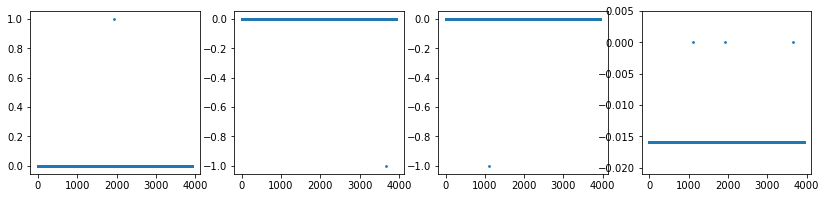

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
for i in range(4):
    ax[i].scatter(np.arange(eigvec.shape[1]), eigvec[:,i], s = 3)
plt.show()

## Agreement Graph

In [25]:
agreement_graph = np.zeros((len(user_ids), len(user_ids)))
agreement_counts = np.zeros((len(user_ids), len(user_ids)))
for pid, annotations in tqdm(polygons.items(), total = len(polygons)):
    annotating_users = list(annotations.keys())
    for i in range(len(annotating_users)):
        u1 = user_ind[annotating_users[i]]
        an1 = annotations[annotating_users[i]]
        
        for j in range(i+1, len(annotating_users)):
            u2 = user_ind[annotating_users[j]]
            an2 = annotations[annotating_users[j]]
            try:
                agreement = annotation_agreement(an1, an2)
            except Exception as e:
                print(pid, annotating_users[i], annotating_users[j])
                raise e
            agreement_graph[u1,u2] += agreement
            agreement_graph[u2,u1] += agreement
            agreement_counts[u1,u2] += 1
            agreement_counts[u2,u1] += 1

agreement_graph /= np.maximum(1, agreement_counts)
agreement_graph[agreement_graph < 1e-14] = 0

In [26]:
(agreement_graph.sum(axis=-1) == 0).sum(), agreement_graph.shape[0]

(10, 3928)

In [27]:
nonisolated_users = np.nonzero(agreement_graph.sum(axis=-1))[0]
nonisolated_user_ind = { user_ids[ui] : i for i, ui in enumerate(nonisolated_users) }
agreement_graph_nonisolated = agreement_graph[np.ix_(nonisolated_users, nonisolated_users)]

## PageRank

In [31]:
P = (1./np.maximum(agreement_graph_nonisolated.sum(axis = -1, keepdims = True), 1e-14)) * agreement_graph_nonisolated
alpha = 0.1
P_damp = (1-alpha)/P.shape[0] * np.ones(P.shape) + alpha * P

eigval, eigvec = scipy.sparse.linalg.eigs(P_damp.T, k=1, which='LR')
if abs(eigval[0] - 1.) < 1e-3:
    pagerank = eigvec[:,0].real
else:
    eigval, eigvec = np.linalg.eig(P_damp.T)
    eigone_ind = np.argmax(np.abs(eigval.real - 1) < 1e-12)
    if np.abs(eigval[eigone_ind].real - 1) > 1e-3:
        print('Deviation of best eigenvalue from 1: {}'.format(np.abs(eigval[eigone_ind].real - 1)))
    pagerank = eigvec[:, eigone_ind].real

if np.abs(np.min(pagerank)) > np.abs(np.max(pagerank)):
    pagerank *= -1
eigval, pagerank

(array([1.+0.j]),
 array([0.01714029, 0.01456274, 0.01469883, ..., 0.01993578, 0.01519039,
        0.01575112]))

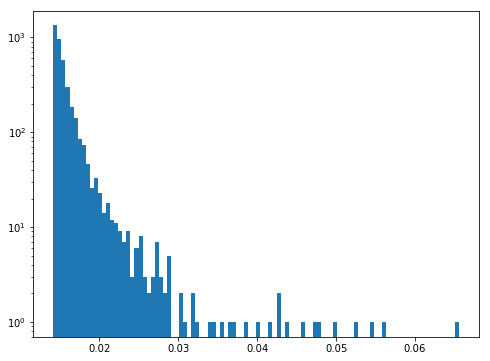

In [32]:
plt.figure(figsize=(8,6))
plt.hist(pagerank, bins = 100, log = True)
plt.show()

### PageRank vs. Number of Contributions

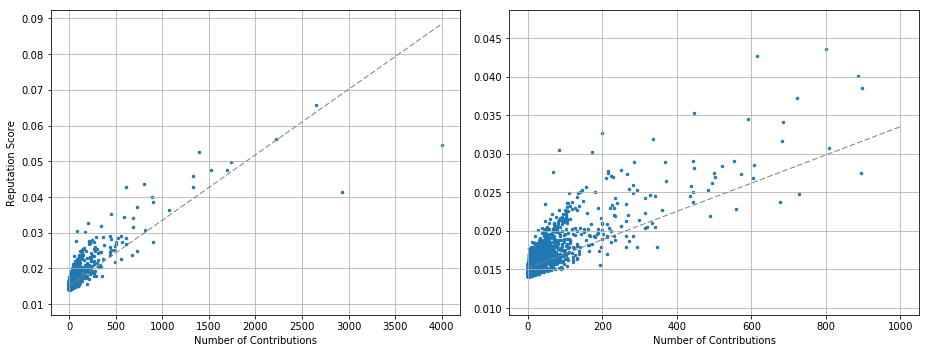

In [64]:
user_contributions = np.array([num_contributions[user_ids[ui]] for ui in nonisolated_users])
a,b=np.linalg.lstsq(np.hstack([user_contributions[:,None], np.ones((len(user_contributions), 1))]), pagerank, rcond=None)[0]
lineX = np.linspace(0, user_contributions.max(), 1000)
linefit = lineX * a + b

fig, axes = plt.subplots(1, 2, figsize = (13, 5))

lineX = np.linspace(0, user_contributions.max(), 1000)
linefit = lineX * a + b
axes[0].scatter(user_contributions, pagerank, s = 6)
axes[0].plot(lineX, linefit, c = 'gray', linewidth = 1, linestyle = '--')

lineX = np.linspace(0, 1000, 1000)
linefit = lineX * a + b
axes[1].scatter(user_contributions[user_contributions <= 1000], pagerank[user_contributions <= 1000], s = 6)
axes[1].plot(lineX, linefit, c = 'gray', linewidth = 1, linestyle = '--')

axes[0].set_ylabel('Reputation Score')
for ax in axes:
    ax.set_xlabel('Number of Contributions')
    ax.grid()
fig.tight_layout()
fig.savefig('building-footprints/pagerank_vs_submissions.svg')
plt.show()

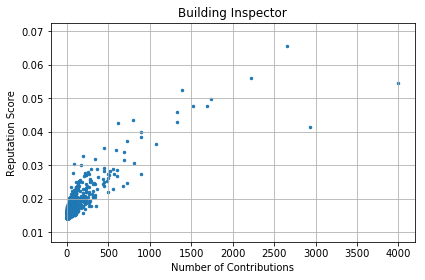

(0.8360017154400033, 0.0)


In [72]:
plt.figure(figsize=(6,4))
plt.scatter(user_contributions, pagerank, s = 6)

plt.title('Building Inspector')
plt.ylabel('Reputation Score')
plt.xlabel('Number of Contributions')
plt.grid()
plt.tight_layout()
plt.savefig('building-footprints/pagerank_vs_submissions_small.svg')
plt.show()

print(scipy.stats.pearsonr(user_contributions, pagerank))

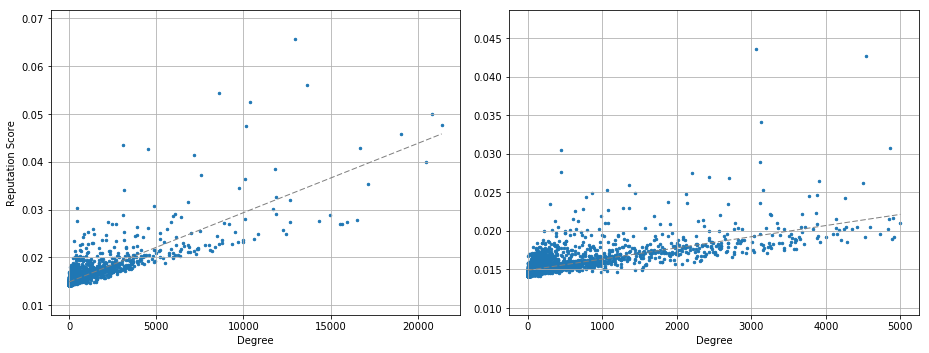

In [34]:
user_degree = collaboration.sum(axis=-1)[nonisolated_users]
a,b=np.linalg.lstsq(np.hstack([user_degree[:,None], np.ones((len(user_degree), 1))]), pagerank, rcond=None)[0]

fig, axes = plt.subplots(1, 2, figsize = (13, 5))

lineX = np.linspace(0, collaboration.sum(axis=-1).max(), 1000)
linefit = lineX * a + b
axes[0].scatter(user_degree, pagerank, s = 6)
axes[0].plot(lineX, linefit, c = 'gray', linewidth = 1, linestyle = '--')

lineX = np.linspace(0, 5000, 1000)
linefit = lineX * a + b
axes[1].scatter(user_degree[user_degree <= 5000], pagerank[user_degree <= 5000], s = 6)
axes[1].plot(lineX, linefit, c = 'gray', linewidth = 1, linestyle = '--')

axes[0].set_ylabel('Reputation Score')
for ax in axes:
    ax.set_xlabel('Degree')
    ax.grid()
fig.tight_layout()
plt.show()

## Evaluation using Ground-Truth

In [35]:
user_correctness = { uid : num_correct[uid] / (num_correct[uid] + num_incorrect[uid])
                     for uid in set(num_correct.keys()) & set(num_incorrect.keys()) }
len(user_correctness)

71

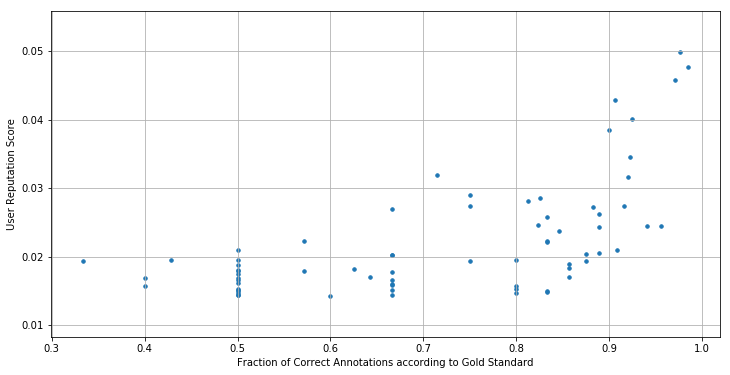

In [36]:
plt.figure(figsize=(12, 6))
plt.scatter(list(user_correctness.values()), [pagerank[nonisolated_user_ind[uid]] for uid in user_correctness.keys()], s = 12)
plt.xlabel('Fraction of Correct Annotations according to Gold Standard')
plt.ylabel('User Reputation Score')
plt.grid()
plt.show()

In [37]:
scipy.stats.pearsonr(list(user_correctness.values()), [pagerank[nonisolated_user_ind[uid]] for uid in user_correctness.keys()])

(0.6026850015152461, 2.679928077334437e-08)

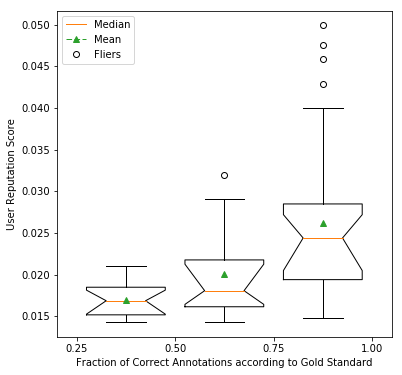

In [38]:
plt.figure(figsize=(6, 6))

artists = plt.boxplot([
        [pagerank[nonisolated_user_ind[uid]] for uid, uc in user_correctness.items() if uc <= 0.5],
        [pagerank[nonisolated_user_ind[uid]] for uid, uc in user_correctness.items() if 0.5 < uc <= 0.75],
        [pagerank[nonisolated_user_ind[uid]] for uid, uc in user_correctness.items() if uc > 0.75]
    ], positions=[0.375, 0.625, 0.875], widths=0.2, notch=True, bootstrap=10000, showmeans=True, manage_xticks=False)

plt.xticks([0.25,0.5,0.75,1.0])
plt.xlim(0.2,1.05)
plt.xlabel('Fraction of Correct Annotations according to Gold Standard')
plt.ylabel('User Reputation Score')
plt.legend([artists['medians'][0], artists['means'][0], artists['fliers'][0]], ['Median', 'Mean', 'Fliers'])
plt.savefig('building-footprints/reputation-vs-gt.svg')
plt.show()

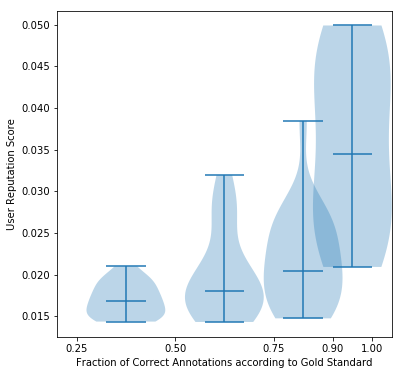

In [39]:
plt.figure(figsize=(6, 6))

artists = plt.violinplot([
        [pagerank[nonisolated_user_ind[uid]] for uid, uc in user_correctness.items() if uc <= 0.5],
        [pagerank[nonisolated_user_ind[uid]] for uid, uc in user_correctness.items() if 0.5 < uc <= 0.75],
        [pagerank[nonisolated_user_ind[uid]] for uid, uc in user_correctness.items() if 0.75 < uc <= 0.9],
        [pagerank[nonisolated_user_ind[uid]] for uid, uc in user_correctness.items() if uc > 0.9]
    ], positions=[0.375, 0.625, 0.825, 0.95], widths=0.2, showmeans=False, showmedians=True)

plt.xticks([0.25,0.5,0.75,0.9,1.0])
plt.xlim(0.2,1.05)
plt.xlabel('Fraction of Correct Annotations according to Gold Standard')
plt.ylabel('User Reputation Score')
plt.show()

## Evolution of Reputation over Time

In [40]:
top_ranked = pagerank.argsort()[::-1][:5]
top_ranked_ids = np.asarray(user_ids)[nonisolated_users[top_ranked]]
top_ranked, top_ranked_ids

(array([2215, 3318,  266, 2563,  818]),
 array([903312077352, 229864209236, 551515923020, 327883322652,
        258905384618]))

In [41]:
pagerank[top_ranked]

array([0.06560259, 0.05613765, 0.05444148, 0.05257911, 0.04992074])

In [42]:
[sum(1 for annotations in polygons.values() if uid in annotations) for uid in top_ranked_ids]

[2649, 2221, 4000, 1389, 1733]

In [43]:
def time_restricted_pagerank(uid, min_pct, max_pct, alpha = 0.8):

    user_pids = np.sort([min(annotations[uid].keys()) for annotations in polygons.values() if uid in annotations])
    min_pid, max_pid = np.percentile(user_pids, [min_pct, max_pct])
    
    A = agreement_graph * agreement_counts
    C = agreement_counts.copy()
    for annotations in polygons.values():
        if uid in annotations:
            u1 = user_ind[uid]
            an1 = annotations[uid]
            pid1 = min(an1.keys())
            if (pid1 < min_pid) or (pid1 > max_pid):
                for uid2, an2 in annotations.items():
                    if uid2 != uid:
                        u2 = user_ind[uid2]
                        agreement = annotation_agreement(an1, an2)
                        A[u1,u2] -= agreement
                        A[u2,u1] -= agreement
                        C[u1,u2] -= 1
                        C[u2,u1] -= 1

    A /= np.maximum(1, C)
    A = A[np.ix_(nonisolated_users, nonisolated_users)]
    A[A < 1e-14] = 0
    
    P = 1./np.maximum(A.sum(axis = -1, keepdims = True), 1e-14) * A
    P_damp = (1-alpha)/P.shape[0] * np.ones(P.shape) + alpha * P

    eigval, eigvec = scipy.sparse.linalg.eigs(P_damp.T, k=1, which='LR')
    if abs(eigval[0] - 1.) < 1e-3:
        pagerank = eigvec[:,0].real
    else:
        eigval, eigvec = np.linalg.eig(P_damp.T)
        pagerank = eigvec[:, np.argmax(np.abs(eigval.real - 1) < 1e-12)].real
    
    if np.abs(np.min(pagerank)) > np.abs(np.max(pagerank)):
        pagerank *= -1
    return pagerank[np.where(nonisolated_users == user_ind[uid])[0][0]] / pagerank.max()

In [56]:
pr_evolution = [
    [time_restricted_pagerank(uid, i, i+20, alpha=0.1) for i in trange(0, 81, 2, desc = 'Sections', leave = False)]
    for uid in tqdm(top_ranked_ids, desc = 'Users')
]

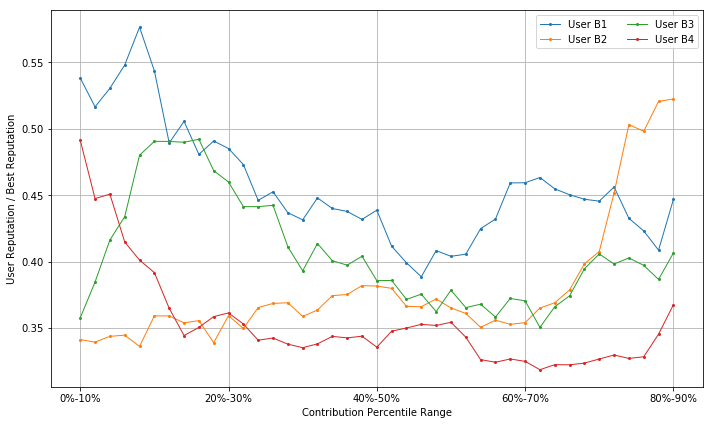

In [86]:
plt.figure(figsize = (10,6))
#plt.figure(figsize = (6,4))
for i, pre in enumerate(pr_evolution[:4], 1):
    plt.plot(np.arange(0, 81, 2), pre, 'o-', linewidth = 1, markersize = 2, label = 'User B{}'.format(i))

plt.grid()
plt.xlabel('Contribution Percentile Range')
plt.ylabel('User Reputation / Best Reputation')
plt.xticks(np.arange(0, 81, 20), ['{}%-{}%'.format(i, i+10) for i in range(0, 81, 20)])

#plt.title('Building Inspector')
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('building-footprints/pagerank_evolution.svg')
plt.show()